# 🍎 FruitSeg30 - Clasificación de Frutas con Deep Learning

## Proyecto de Clasificación y Búsqueda de Similaridad

Este notebook implementa múltiples arquitecturas de Deep Learning para clasificación de 30 tipos de frutas:

1. **CNN desde cero** - Arquitectura convolucional diseñada manualmente
2. **ViT/Swin Transformer** - Transfer learning con transformers visuales
3. **Red Siamesa + Contrastive Loss** → Clasificación con FC layer
4. **Red Siamesa + Contrastive Loss** → Clasificación con XGBoost
5. **Red Siamesa + Triplet Loss** → Clasificación con FC layer
6. **Red Siamesa + Triplet Loss** → Clasificación con XGBoost
7. **Buscador de Similaridad** - Top 10 imágenes similares

---

## 1. Setup e Importación de Librerías

## Metodología Propuesta

### 1. Descripción del Dataset

#### 1.1 FruitSeg30 Dataset
El dataset **FruitSeg30** es un conjunto de datos público diseñado para tareas de clasificación y segmentación de frutas, compuesto por:

| Característica | Valor |
|---------------|-------|
| **Total de imágenes** | 1,969 |
| **Número de clases** | 30 |
| **Resolución original** | 512 × 512 píxeles |
| **Formato de imágenes** | JPG |
| **Formato de máscaras** | PNG |

#### 1.2 Clases del Dataset
Las 30 categorías de frutas incluidas son:

| Categoría | Subcategorías |
|-----------|---------------|
| **Manzanas** | Apple_Gala, Apple_Golden Delicious |
| **Mangos** | Mango_Alphonso, Mango_Amrapali, Mango_Bari, Mango_Himsagar, Mango Golden Queen |
| **Frutas tropicales** | Avocado, Banana, Pineapple, Dragon, Carambola, Green Coconut, Guava |
| **Bayas y uvas** | Berry, Grape, Burmese Grape, Lichi |
| **Cítricos** | Orange, Malta, Kiwi |
| **Frutas de hueso** | Date Palm, Palm, Olive, Hog Plum, Persimmon |
| **Otras frutas** | Pomegranate, Watermelon, White Pear, Elephant Apple |

#### 1.3 Estructura del Dataset
```
data/
├── [Nombre_Fruta]/
│   ├── Images/          # Imágenes RGB en formato JPG
│   └── Mask/            # Máscaras de segmentación en PNG
```

---

### 2. Protocolo Experimental

#### 2.1 División de Datos
Se implementa una división estratificada para mantener la proporción de clases en cada conjunto:

| Conjunto | Porcentaje | Propósito |
|----------|------------|-----------|
| **Entrenamiento** | 70% | Aprendizaje de parámetros del modelo |
| **Validación** | 15% | Ajuste de hiperparámetros y early stopping |
| **Test** | 15% | Evaluación final del rendimiento |

> **Nota:** Se utiliza `stratify` en `train_test_split` para garantizar representación proporcional de todas las clases.

#### 2.2 Preprocesamiento de Datos

**Transformaciones para Entrenamiento (Data Augmentation):**
- Redimensionamiento a 224 × 224 píxeles
- Flip horizontal aleatorio (p=0.5)
- Flip vertical aleatorio (p=0.3)
- Rotación aleatoria (±15°)
- Color Jitter (brillo, contraste, saturación, tono)
- Transformación afín aleatoria
- Normalización ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

**Transformaciones para Validación/Test:**
- Redimensionamiento a 224 × 224 píxeles
- Normalización ImageNet

#### 2.3 Configuración de Entrenamiento

| Parámetro | CNN | Swin Transformer | Redes Siamesas |
|-----------|-----|------------------|----------------|
| **Épocas** | 50 | 30 | 50 |
| **Learning Rate** | 1e-3 | 1e-4 | 1e-4 |
| **Batch Size** | 32 | 32 | 32 |
| **Optimizer** | AdamW | AdamW | AdamW |
| **Weight Decay** | 1e-3 | 1e-4 | 1e-4 |
| **Scheduler** | CosineAnnealingLR | CosineAnnealingLR | CosineAnnealingLR |

#### 2.4 Arquitecturas Implementadas

##### A. CNN desde Cero
- Arquitectura simplificada tipo VGG con 5 bloques convolucionales
- Canales: 32 → 64 → 128 → 256 → 256
- Dropout2d progresivo (0.1 → 0.3) para regularización
- Global Average Pooling + Clasificador FC

##### B. Swin Transformer (Transfer Learning)
- Backbone: Swin-T preentrenado en ImageNet
- Fine-tuning completo de todas las capas
- Cabeza de clasificación personalizada (768 → 512 → 30)

##### C. Redes Siamesas
- **Backbone:** ResNet18 preentrenado
- **Dimensión de embedding:** 128
- **Funciones de pérdida:**
  - Contrastive Loss (margin=2.0)
  - Triplet Loss (margin=1.0)
- **Clasificadores downstream:**
  - Fully Connected (embedding → 256 → 128 → 30)
  - XGBoost (n_estimators=200, max_depth=6)

#### 2.5 Métricas de Evaluación

| Métrica | Descripción |
|---------|-------------|
| **Accuracy** | Proporción de predicciones correctas |
| **Precision** | TP / (TP + FP) por clase |
| **Recall** | TP / (TP + FN) por clase |
| **F1-Score** | Media armónica de Precision y Recall |
| **Matriz de Confusión** | Visualización de errores por clase |
| **Precision@K** | Precisión en búsqueda de similaridad (Top-10) |

#### 2.6 Reproducibilidad
- **Semilla fija:** 42 para todas las operaciones aleatorias
- **Determinismo CUDA:** `torch.backends.cudnn.deterministic = True`
- **Entorno:** PyTorch 2.x, CUDA (si disponible)

---

### 3. Resumen de Experimentos

```
┌─────────────────────────────────────────────────────────────────┐
│                    PIPELINE EXPERIMENTAL                        │
├─────────────────────────────────────────────────────────────────┤
│  Dataset FruitSeg30 (1969 imágenes, 30 clases)                 │
│           ↓                                                     │
│  Split: Train (70%) / Val (15%) / Test (15%)                   │
│           ↓                                                     │
│  ┌───────────────┬───────────────┬───────────────┐             │
│  │   CNN desde   │     Swin      │    Redes      │             │
│  │     cero      │  Transformer  │   Siamesas    │             │
│  └───────┬───────┴───────┬───────┴───────┬───────┘             │
│          ↓               ↓               ↓                      │
│  ┌───────────────────────────────────────────────┐             │
│  │           Clasificación (30 clases)           │             │
│  └───────────────────────────────────────────────┘             │
│          ↓               ↓               ↓                      │
│  ┌───────────────────────────────────────────────┐             │
│  │   Evaluación: Accuracy, F1, Confusion Matrix  │             │
│  └───────────────────────────────────────────────┘             │
│                          ↓                                      │
│  ┌───────────────────────────────────────────────┐             │
│  │      Buscador de Similaridad (Top-10 KNN)     │             │
│  └───────────────────────────────────────────────┘             │
└─────────────────────────────────────────────────────────────────┘
```

In [14]:
# Librerías básicas
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Torchvision
import torchvision
from torchvision import transforms, models
from torchvision.models import swin_t, Swin_T_Weights

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost no disponible. Se omitirán las secciones con XGBoost.")

# Progress bar
from tqdm.auto import tqdm

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Semilla para reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("✅ Semilla establecida: 42")

🖥️ Dispositivo: cuda
   GPU: NVIDIA GeForce RTX 4060 Laptop GPU
   Memoria GPU: 8.59 GB
✅ Semilla establecida: 42


## 2. Configuración y Carga de Datos

In [15]:
# Configuración del proyecto
class Config:
    # Rutas
    DATA_DIR = Path("data")
    
    # Parámetros de imagen
    IMG_SIZE = 224  # Tamaño para modelos preentrenados
    ORIGINAL_SIZE = 512  # Tamaño original del dataset
    
    # Parámetros de entrenamiento
    BATCH_SIZE = 32
    NUM_WORKERS = 0
    NUM_EPOCHS_CNN = 50
    NUM_EPOCHS_SWIN = 30
    NUM_EPOCHS_SIAMESE = 50
    
    # Learning rates
    LR_CNN = 1e-3
    LR_SWIN = 1e-4
    LR_SIAMESE = 1e-4
    
    # Split de datos
    TRAIN_RATIO = 0.70
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    
    # Número de clases
    NUM_CLASSES = 30
    
    # Embedding dimension para redes siamesas
    EMBEDDING_DIM = 128

config = Config()
print("✅ Configuración cargada")

✅ Configuración cargada


In [16]:
# Explorar el dataset
def explore_dataset(data_dir):
    """Explora el dataset y devuelve información sobre las clases"""
    data_dir = Path(data_dir)
    
    class_info = []
    all_images = []
    all_labels = []
    
    for class_folder in sorted(data_dir.iterdir()):
        if class_folder.is_dir():
            images_folder = class_folder / "Images"
            if images_folder.exists():
                images = list(images_folder.glob("*.jpg")) + list(images_folder.glob("*.JPG"))
                class_name = class_folder.name
                
                for img_path in images:
                    all_images.append(str(img_path))
                    all_labels.append(class_name)
                
                class_info.append({
                    'class': class_name,
                    'num_images': len(images)
                })
    
    df_classes = pd.DataFrame(class_info)
    return df_classes, all_images, all_labels

# Explorar dataset
df_classes, all_images, all_labels = explore_dataset(config.DATA_DIR)

print(f"📊 Estadísticas del Dataset FruitSeg30:")
print(f"   • Total de clases: {len(df_classes)}")
print(f"   • Total de imágenes: {len(all_images)}")
print(f"   • Imágenes por clase (promedio): {len(all_images)/len(df_classes):.1f}")
print(f"\n📈 Distribución de imágenes por clase:")
print(df_classes.to_string(index=False))

📊 Estadísticas del Dataset FruitSeg30:
   • Total de clases: 30
   • Total de imágenes: 3938
   • Imágenes por clase (promedio): 131.3

📈 Distribución de imágenes por clase:
                 class  num_images
            Apple_Gala         130
Apple_Golden Delicious         114
               Avocado         144
                Banana         164
                 Berry         124
         Burmese Grape         156
             Carambola         200
             Date Palm         294
                Dragon         192
        Elephant Apple         162
                 Grape         164
         Green Coconut          74
                 Guava         110
              Hog Plum         182
                  Kiwi         122
                 Lichi          96
                 Malta         100
    Mango Golden Queen          32
        Mango_Alphonso          90
        Mango_Amrapali         134
            Mango_Bari         114
        Mango_Himsagar         170
                 Oliv

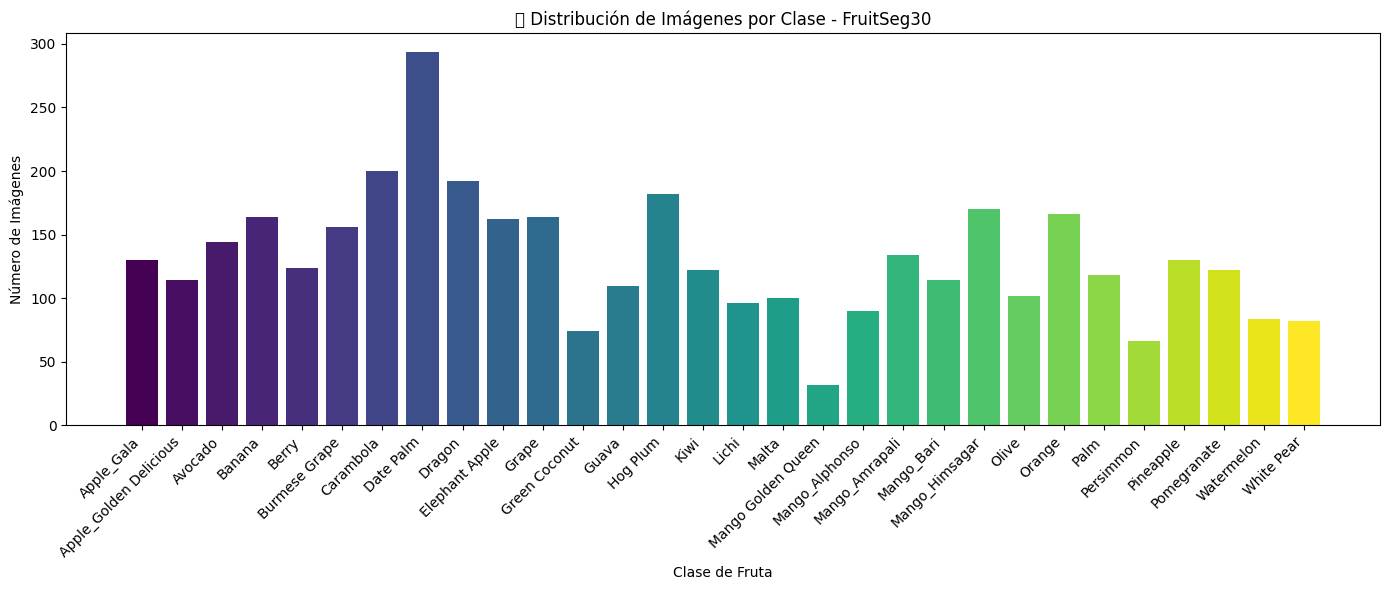

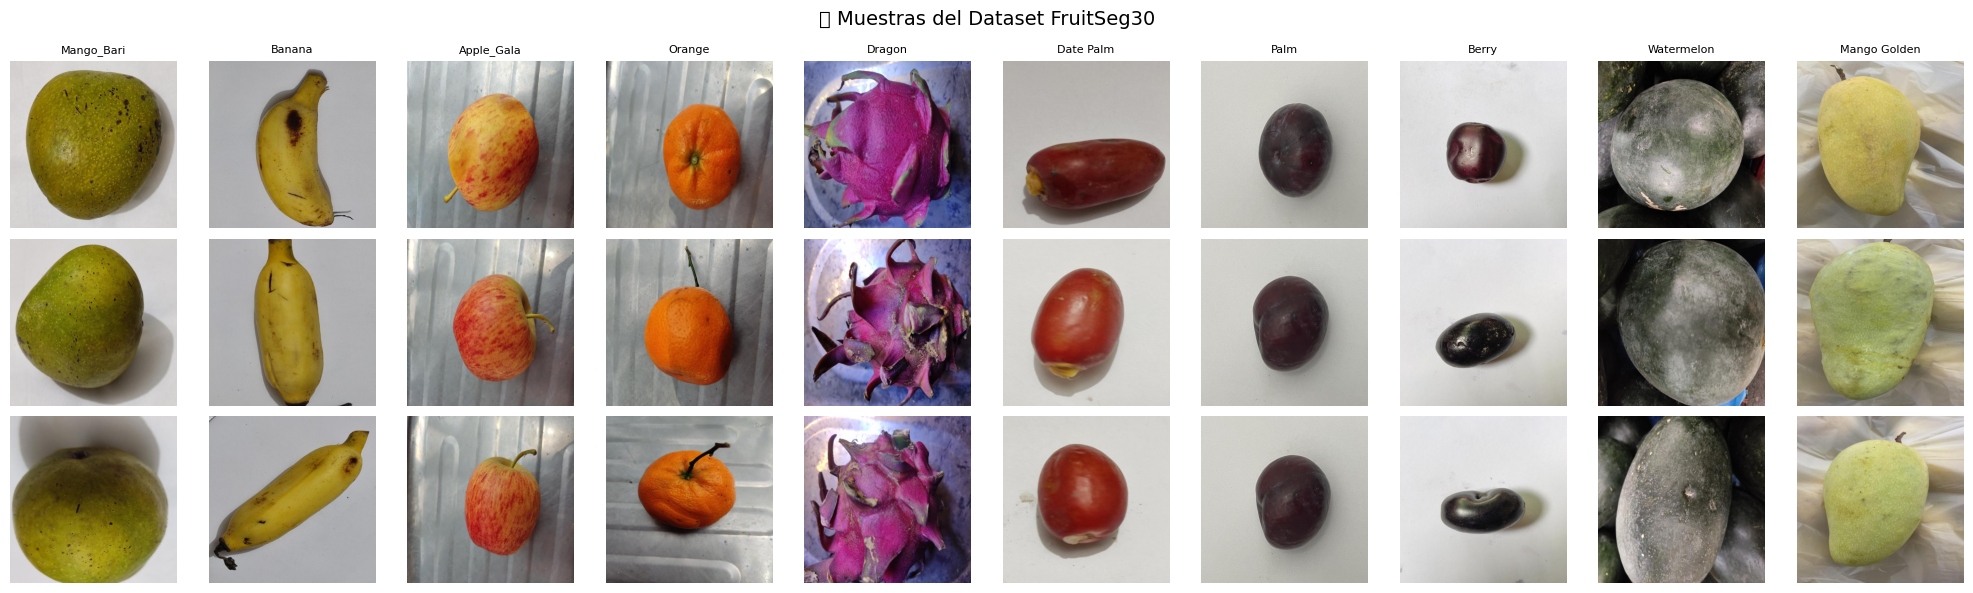

In [17]:
# Visualizar distribución de clases
plt.figure(figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(df_classes)))
bars = plt.bar(range(len(df_classes)), df_classes['num_images'], color=colors)
plt.xticks(range(len(df_classes)), df_classes['class'], rotation=45, ha='right')
plt.xlabel('Clase de Fruta')
plt.ylabel('Número de Imágenes')
plt.title('📊 Distribución de Imágenes por Clase - FruitSeg30')
plt.tight_layout()
plt.show()

# Visualizar algunas imágenes de ejemplo
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
sampled_classes = random.sample(list(df_classes['class']), min(10, len(df_classes)))

for idx, class_name in enumerate(sampled_classes):
    # Obtener imágenes de esta clase
    class_images = [img for img, lbl in zip(all_images, all_labels) if lbl == class_name]
    
    for row in range(3):
        if row < len(class_images):
            img = Image.open(class_images[row])
            axes[row, idx].imshow(img)
        axes[row, idx].axis('off')
        if row == 0:
            axes[row, idx].set_title(class_name[:12], fontsize=8)

plt.suptitle('🍎 Muestras del Dataset FruitSeg30', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Preparación de Datos y Data Augmentation

In [18]:
# Transformaciones para entrenamiento y validación/test
train_transforms = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Transformaciones definidas")
print(f"   • Train: Resize, Flips, Rotación, ColorJitter, Affine, Normalize")
print(f"   • Val/Test: Resize, Normalize")

✅ Transformaciones definidas
   • Train: Resize, Flips, Rotación, ColorJitter, Affine, Normalize
   • Val/Test: Resize, Normalize


In [19]:
# Dataset personalizado para clasificación
class FruitDataset(Dataset):
    """Dataset para clasificación de frutas"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        # Crear codificador de etiquetas
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)
        self.num_classes = len(self.label_encoder.classes_)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.encoded_labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def get_class_names(self):
        return self.label_encoder.classes_

# Crear dataset completo para obtener el label encoder
full_dataset = FruitDataset(all_images, all_labels, transform=None)
label_encoder = full_dataset.label_encoder
class_names = full_dataset.get_class_names()

print(f"✅ Dataset creado")
print(f"   • Total imágenes: {len(full_dataset)}")
print(f"   • Clases: {len(class_names)}")

✅ Dataset creado
   • Total imágenes: 3938
   • Clases: 30


In [20]:
# Split estratificado: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, 
    test_size=0.30, 
    stratify=all_labels, 
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    stratify=y_temp, 
    random_state=42
)

print(f"📊 Split de datos:")
print(f"   • Train: {len(X_train)} imágenes ({len(X_train)/len(all_images)*100:.1f}%)")
print(f"   • Validation: {len(X_val)} imágenes ({len(X_val)/len(all_images)*100:.1f}%)")
print(f"   • Test: {len(X_test)} imágenes ({len(X_test)/len(all_images)*100:.1f}%)")

# Verificar distribución de clases en cada split
def check_distribution(labels, name):
    counter = Counter(labels)
    print(f"\n   {name}: min={min(counter.values())}, max={max(counter.values())}, media={np.mean(list(counter.values())):.1f}")

check_distribution(y_train, "Train")
check_distribution(y_val, "Val")
check_distribution(y_test, "Test")

📊 Split de datos:
   • Train: 2756 imágenes (70.0%)
   • Validation: 591 imágenes (15.0%)
   • Test: 591 imágenes (15.0%)

   Train: min=23, max=206, media=91.9

   Val: min=4, max=44, media=19.7

   Test: min=5, max=44, media=19.7


In [21]:
# Crear datasets con transformaciones
train_dataset = FruitDataset(X_train, y_train, transform=train_transforms)
val_dataset = FruitDataset(X_val, y_val, transform=val_test_transforms)
test_dataset = FruitDataset(X_test, y_test, transform=val_test_transforms)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)

print(f"✅ DataLoaders creados")
print(f"   • Train batches: {len(train_loader)}")
print(f"   • Val batches: {len(val_loader)}")
print(f"   • Test batches: {len(test_loader)}")

✅ DataLoaders creados
   • Train batches: 87
   • Val batches: 19
   • Test batches: 19


## 4. Funciones de Entrenamiento y Evaluación

In [22]:
# Funciones de entrenamiento y evaluación
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena el modelo por una época"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Valida el modelo"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate_model(model, test_loader, device, class_names):
    """Evalúa el modelo en el conjunto de test"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n📊 Accuracy en Test: {accuracy*100:.2f}%")
    
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    return all_labels, all_preds

def plot_training_history(train_losses, val_losses, train_accs, val_accs, title="Training History"):
    """Visualiza el historial de entrenamiento"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy
    ax2.plot(train_accs, label='Train Acc', color='blue')
    ax2.plot(val_accs, label='Val Acc', color='red')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """Visualiza la matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("✅ Funciones de entrenamiento y evaluación definidas")

✅ Funciones de entrenamiento y evaluación definidas


## 5. CNN desde Cero - Clasificación

Arquitectura convolucional diseñada manualmente con:
- Bloques convolucionales con BatchNorm y MaxPooling
- Global Average Pooling
- Capas fully connected con Dropout

In [23]:
# Arquitectura CNN desde cero (Simplificada para evitar overfitting)
class ConvBlock(nn.Module):
    """Bloque convolucional con BatchNorm y ReLU"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class FruitCNN(nn.Module):
    """CNN simplificada para clasificación de frutas - menos parámetros para evitar overfitting"""
    def __init__(self, num_classes=30, dropout_rate=0.5):
        super(FruitCNN, self).__init__()
        
        # Bloque 1: 3 -> 32 canales (reducido de 64)
        self.block1 = nn.Sequential(
            ConvBlock(3, 32),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2)  # 224 -> 112
        )
        
        # Bloque 2: 32 -> 64 canales (reducido de 128)
        self.block2 = nn.Sequential(
            ConvBlock(32, 64),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2)  # 112 -> 56
        )
        
        # Bloque 3: 64 -> 128 canales (reducido de 256)
        self.block3 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2)  # 56 -> 28
        )
        
        # Bloque 4: 128 -> 256 canales (reducido de 512)
        self.block4 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 256),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2, 2)  # 28 -> 14
        )
        
        # Bloque 5: 256 -> 256 canales (reducido de 512)
        self.block5 = nn.Sequential(
            ConvBlock(256, 256),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2, 2)  # 14 -> 7
        )
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Clasificador más simple
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
        
        # Inicialización de pesos
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

# Crear modelo
cnn_model = FruitCNN(num_classes=config.NUM_CLASSES, dropout_rate=0.5).to(device)

# Mostrar arquitectura
print("🏗️ Arquitectura CNN desde cero (Simplificada):")
print(f"   • Parámetros totales: {sum(p.numel() for p in cnn_model.parameters()):,}")
print(f"   • Parámetros entrenables: {sum(p.numel() for p in cnn_model.parameters() if p.requires_grad):,}")

🏗️ Arquitectura CNN desde cero (Simplificada):
   • Parámetros totales: 1,755,166
   • Parámetros entrenables: 1,755,166


In [ ]:
# Entrenamiento de la CNN desde cero
def train_cnn_model(model, train_loader, val_loader, num_epochs, lr, device, model_name="CNN", patience=10):
    """Función completa de entrenamiento con early stopping basado en val_loss"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)  # Más weight decay
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')  # Guardamos por LOSS, no accuracy
    best_model_state = None
    epochs_no_improve = 0  # Contador para early stopping
    
    print(f"\n🚀 Iniciando entrenamiento de {model_name}")
    print(f"   • Épocas: {num_epochs}")
    print(f"   • Learning Rate: {lr}")
    print(f"   • Early Stopping patience: {patience}")
    print("-" * 80)
    print(f"{'Epoch':^8} | {'Train Loss':^12} | {'Train Acc':^12} | {'Val Loss':^12} | {'Val Acc':^12} | {'Best':^6}")
    print("-" * 80)
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        scheduler.step()
        
        # Guardar mejor modelo basado en val_loss (no accuracy)
        is_best = ""
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc  # Guardamos también el acc del mejor modelo
            best_model_state = model.state_dict().copy()
            is_best = "✓"
            epochs_no_improve = 0  # Reset contador
        else:
            epochs_no_improve += 1
        
        # Mostrar TODAS las épocas
        print(f"{epoch+1:^8} | {train_loss:^12.4f} | {train_acc:^11.2f}% | {val_loss:^12.4f} | {val_acc:^11.2f}% | {is_best:^6}")
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f"\n⚠️ Early stopping activado en época {epoch+1} (sin mejora por {patience} épocas)")
            break
    
    print("-" * 80)
    
    # Cargar mejor modelo
    model.load_state_dict(best_model_state)
    print(f"\n✅ Mejor modelo guardado - Val Loss: {best_val_loss:.4f} | Val Acc: {best_val_acc:.2f}%")
    
    return model, train_losses, val_losses, train_accs, val_accs

# Entrenar CNN
cnn_model, cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_cnn_model(
    cnn_model, train_loader, val_loader, 
    num_epochs=config.NUM_EPOCHS_CNN, 
    lr=config.LR_CNN, 
    device=device,
    model_name="CNN desde cero",
    patience=10  # Early stopping patience
)


🚀 Iniciando entrenamiento de CNN desde cero
   • Épocas: 50
   • Learning Rate: 0.001
--------------------------------------------------------------------------------
 Epoch   |  Train Loss  |  Train Acc   |   Val Loss   |   Val Acc    |  Best 
--------------------------------------------------------------------------------


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   1     |    3.3365    |    10.27   % |    2.5488    |    29.27   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   2     |    2.8145    |    18.87   % |    2.0955    |    31.13   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   3     |    2.4598    |    24.17   % |    1.5568    |    47.55   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   4     |    2.2323    |    30.01   % |    1.4064    |    50.42   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   5     |    2.0261    |    35.74   % |    1.5722    |    40.27   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   6     |    1.8583    |    39.91   % |    0.9266    |    76.31   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   7     |    1.7910    |    40.75   % |    1.3177    |    51.10   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   8     |    1.6523    |    46.15   % |    1.0660    |    62.77   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   9     |    1.6194    |    47.82   % |    0.7545    |    78.85   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   10    |    1.5976    |    47.46   % |    0.8635    |    74.45   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   11    |    1.4762    |    51.89   % |    0.7532    |    71.74   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   12    |    1.4481    |    51.05   % |    0.7860    |    73.27   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   13    |    1.3967    |    53.92   % |    0.6961    |    78.85   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   14    |    1.4272    |    52.79   % |    0.6162    |    81.90   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   15    |    1.3296    |    54.64   % |    0.6678    |    79.53   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   16    |    1.2768    |    57.66   % |    0.8501    |    71.40   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   17    |    1.2644    |    57.76   % |    0.5306    |    86.13   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   18    |    1.1808    |    60.74   % |    0.5786    |    81.22   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   19    |    1.2046    |    62.30   % |    0.5627    |    81.39   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   20    |    1.0769    |    64.44   % |    0.4564    |    85.79   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   21    |    1.1606    |    61.28   % |    0.4780    |    87.99   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   22    |    1.1176    |    62.52   % |    0.4284    |    88.32   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   23    |    1.0797    |    64.19   % |    0.5034    |    84.43   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   24    |    1.0612    |    63.57   % |    0.4469    |    87.99   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   25    |    1.0287    |    65.53   % |    0.6453    |    76.48   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   26    |    1.0387    |    67.49   % |    0.3785    |    88.83   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   27    |    1.0392    |    64.80   % |    0.4174    |    87.48   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   28    |    1.0036    |    65.75   % |    0.4488    |    84.94   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   29    |    0.9935    |    68.21   % |    0.3852    |    88.49   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   30    |    0.9307    |    68.32   % |    0.5045    |    82.23   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   31    |    0.8871    |    69.67   % |    0.4318    |    85.96   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   32    |    0.9319    |    69.19   % |    0.3981    |    87.82   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   33    |    0.9109    |    70.43   % |    0.3618    |    90.86   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   34    |    0.8933    |    69.70   % |    0.3544    |    89.51   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   35    |    0.8711    |    70.79   % |    0.3743    |    90.02   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   36    |    0.8472    |    71.44   % |    0.3516    |    89.00   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   37    |    0.8364    |    71.34   % |    0.3340    |    90.19   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   38    |    0.8072    |    72.93   % |    0.3197    |    90.19   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   39    |    0.8062    |    73.40   % |    0.3490    |    88.83   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   40    |    0.8668    |    71.01   % |    0.3429    |    89.00   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   41    |    0.7916    |    73.26   % |    0.3707    |    88.16   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   42    |    0.8107    |    73.33   % |    0.3180    |    90.36   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   43    |    0.7821    |    72.06   % |    0.3206    |    90.02   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   44    |    0.8144    |    73.80   % |    0.2819    |    91.88   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   45    |    0.8063    |    72.35   % |    0.3172    |    90.52   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   46    |    0.8086    |    73.33   % |    0.3093    |    90.69   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   47    |    0.7838    |    73.91   % |    0.3214    |    89.85   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   48    |    0.7801    |    73.73   % |    0.3138    |    90.52   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   49    |    0.7876    |    73.88   % |    0.3169    |    90.19   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   50    |    0.7899    |    72.93   % |    0.3174    |    90.19   % |       
--------------------------------------------------------------------------------

✅ Mejor Val Accuracy: 91.88%


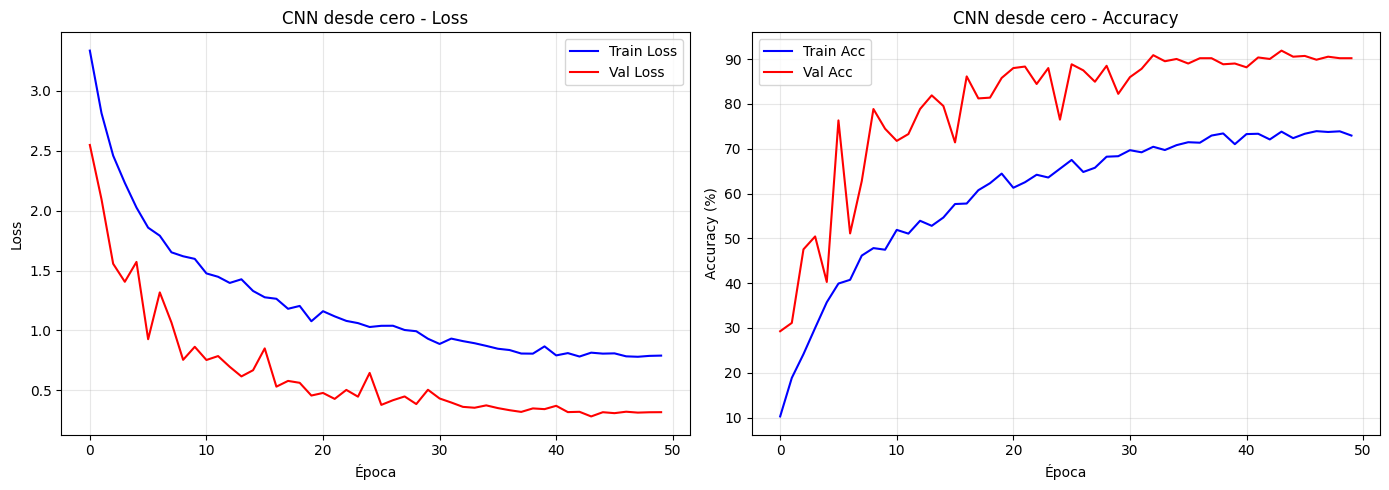

In [25]:
# Visualizar historial de entrenamiento CNN
plot_training_history(cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs, 
                      title="CNN desde cero")

📊 Evaluación de CNN desde cero en conjunto de Test:


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


📊 Accuracy en Test: 90.19%

📋 Classification Report:
                        precision    recall  f1-score   support

            Apple_Gala       0.61      1.00      0.76        19
Apple_Golden Delicious       0.94      0.94      0.94        17
               Avocado       1.00      1.00      1.00        21
                Banana       0.89      1.00      0.94        25
                 Berry       1.00      0.94      0.97        18
         Burmese Grape       0.92      0.92      0.92        24
             Carambola       0.93      0.87      0.90        30
             Date Palm       0.98      1.00      0.99        44
                Dragon       1.00      1.00      1.00        29
        Elephant Apple       1.00      0.88      0.93        24
                 Grape       0.89      1.00      0.94        25
         Green Coconut       1.00      1.00      1.00        11
                 Guava       0.94      1.00      0.97        17
              Hog Plum       0.81      0.93      

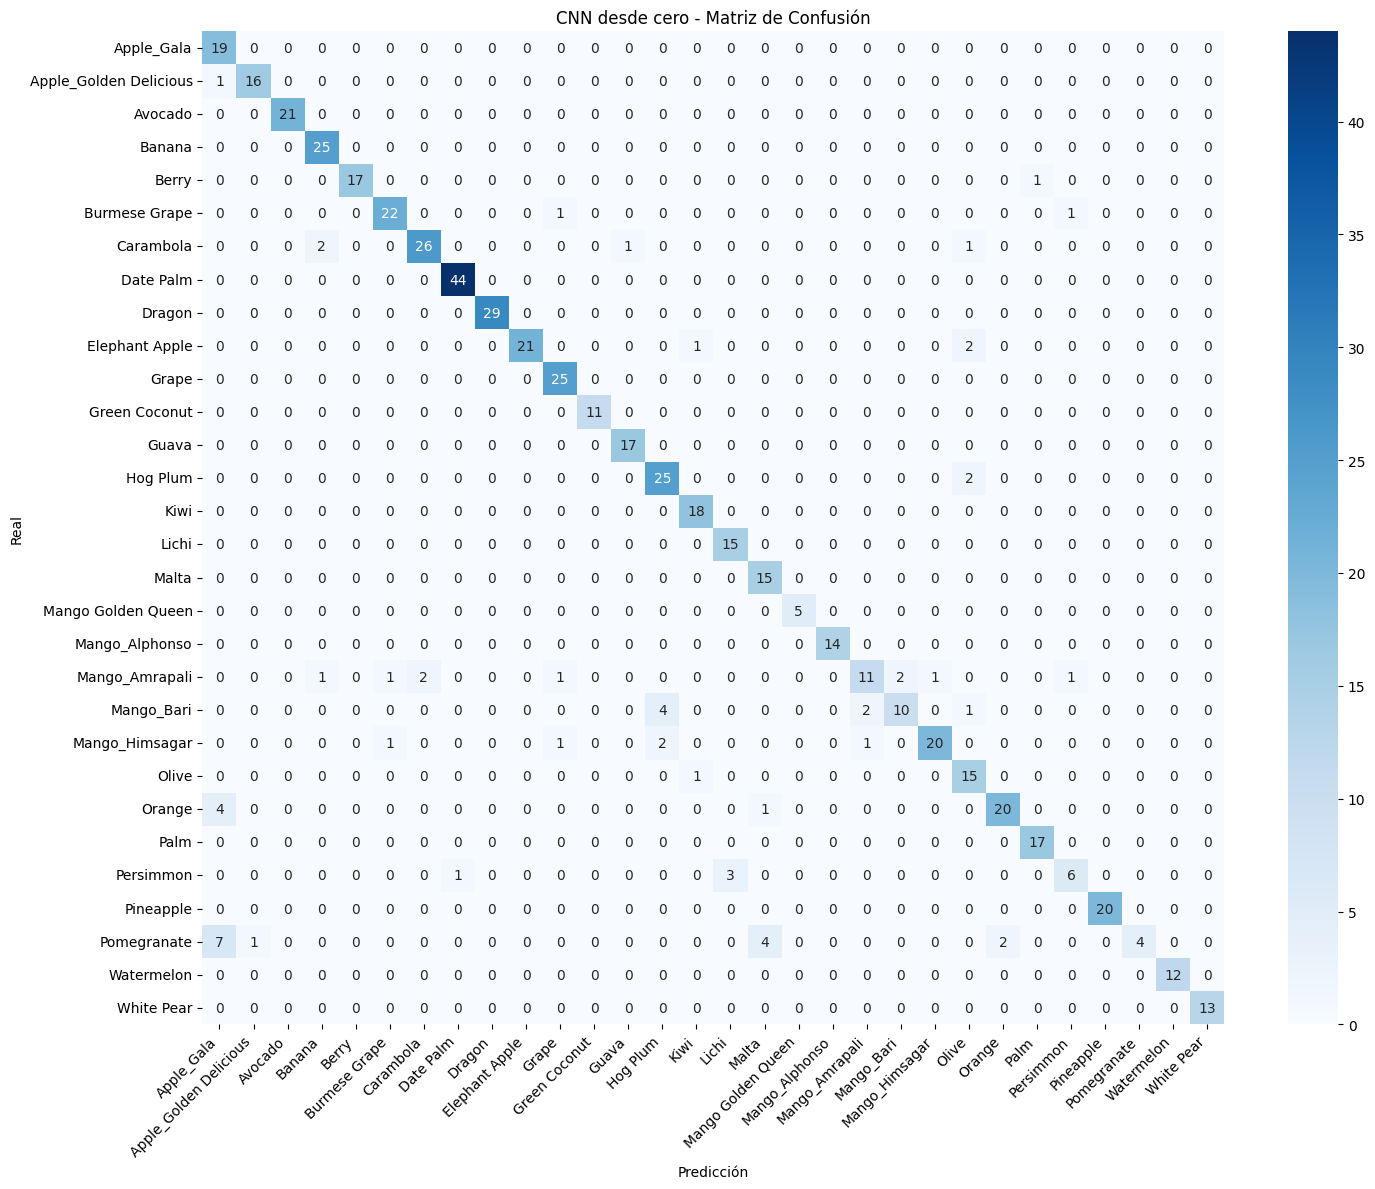

In [26]:
# Evaluar CNN en test
print("📊 Evaluación de CNN desde cero en conjunto de Test:")
cnn_labels, cnn_preds = evaluate_model(cnn_model, test_loader, device, class_names)

# Matriz de confusión
plot_confusion_matrix(cnn_labels, cnn_preds, class_names, title="CNN desde cero - Matriz de Confusión")

## 6. Swin Transformer - Transfer Learning

Utilizamos Swin Transformer Tiny preentrenado en ImageNet:
- Fine-tuning de todas las capas
- Cabeza de clasificación personalizada para 30 clases

In [27]:
# Modelo Swin Transformer con Transfer Learning
class SwinClassifier(nn.Module):
    """Swin Transformer para clasificación de frutas"""
    def __init__(self, num_classes=30, pretrained=True):
        super(SwinClassifier, self).__init__()
        
        # Cargar Swin Transformer preentrenado
        if pretrained:
            self.swin = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)
        else:
            self.swin = swin_t(weights=None)
        
        # Obtener dimensión de features
        in_features = self.swin.head.in_features
        
        # Reemplazar cabeza de clasificación
        self.swin.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.swin(x)

# Crear modelo Swin
swin_model = SwinClassifier(num_classes=config.NUM_CLASSES, pretrained=True).to(device)

print("🏗️ Arquitectura Swin Transformer:")
print(f"   • Parámetros totales: {sum(p.numel() for p in swin_model.parameters()):,}")
print(f"   • Parámetros entrenables: {sum(p.numel() for p in swin_model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to C:\Users\Marcelo/.cache\torch\hub\checkpoints\swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:17<00:00, 6.57MB/s] 



🏗️ Arquitectura Swin Transformer:
   • Parámetros totales: 27,928,472
   • Parámetros entrenables: 27,928,472


In [28]:
# Entrenar Swin Transformer
swin_model, swin_train_losses, swin_val_losses, swin_train_accs, swin_val_accs = train_cnn_model(
    swin_model, train_loader, val_loader, 
    num_epochs=config.NUM_EPOCHS_SWIN, 
    lr=config.LR_SWIN, 
    device=device,
    model_name="Swin Transformer"
)


🚀 Iniciando entrenamiento de Swin Transformer
   • Épocas: 30
   • Learning Rate: 0.0001
--------------------------------------------------------------------------------
 Epoch   |  Train Loss  |  Train Acc   |   Val Loss   |   Val Acc    |  Best 
--------------------------------------------------------------------------------


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   1     |    1.3458    |    70.07   % |    0.0742    |    98.65   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   2     |    0.1201    |    97.71   % |    0.0095    |    99.83   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   3     |    0.0669    |    98.51   % |    0.0519    |    98.48   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   4     |    0.1000    |    97.21   % |    0.0094    |    99.83   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   5     |    0.0403    |    98.84   % |    0.0023    |   100.00   % |   ✓   


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   6     |    0.0323    |    99.13   % |    0.0030    |    99.83   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   7     |    0.0234    |    99.46   % |    0.0008    |   100.00   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   8     |    0.0158    |    99.78   % |    0.0004    |   100.00   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   9     |    0.0049    |   100.00   % |    0.0002    |   100.00   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   10    |    0.0147    |    99.67   % |    0.0056    |    99.83   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   11    |    0.0166    |    99.71   % |    0.0002    |   100.00   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   12    |    0.0120    |    99.60   % |    0.0002    |   100.00   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   13    |    0.0109    |    99.78   % |    0.0048    |    99.83   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   14    |    0.0190    |    99.49   % |    0.0003    |   100.00   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

   15    |    0.0071    |    99.89   % |    0.0001    |   100.00   % |       


Training:   0%|          | 0/87 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Visualizar historial de entrenamiento Swin
plot_training_history(swin_train_losses, swin_val_losses, swin_train_accs, swin_val_accs, 
                      title="Swin Transformer")

In [ ]:
# Evaluar Swin en test
print("📊 Evaluación de Swin Transformer en conjunto de Test:")
swin_labels, swin_preds = evaluate_model(swin_model, test_loader, device, class_names)

# Matriz de confusión
plot_confusion_matrix(swin_labels, swin_preds, class_names, title="Swin Transformer - Matriz de Confusión")

## 7. Red Siamesa + Contrastive Loss

Implementación de una red siamesa para aprendizaje de similaridad:
- Backbone: ResNet18 preentrenado
- Contrastive Loss para aprender embeddings
- Clasificación mediante FC layer y XGBoost

In [ ]:
# Dataset para pares de imágenes (Siamese)
class SiameseDataset(Dataset):
    """Dataset que genera pares de imágenes para red siamesa"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        # Organizar imágenes por clase
        self.class_to_indices = {}
        for idx, label in enumerate(labels):
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)
        
        self.classes = list(self.class_to_indices.keys())
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img1_path = self.image_paths[idx]
        label1 = self.labels[idx]
        
        # 50% pares positivos (misma clase), 50% pares negativos
        if random.random() > 0.5:
            # Par positivo
            idx2 = random.choice(self.class_to_indices[label1])
            same_class = 1
        else:
            # Par negativo
            other_classes = [c for c in self.classes if c != label1]
            other_class = random.choice(other_classes)
            idx2 = random.choice(self.class_to_indices[other_class])
            same_class = 0
        
        img2_path = self.image_paths[idx2]
        
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(same_class, dtype=torch.float32)

# Crear datasets siameses
siamese_train_dataset = SiameseDataset(X_train, y_train, transform=train_transforms)
siamese_val_dataset = SiameseDataset(X_val, y_val, transform=val_test_transforms)

siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=config.BATCH_SIZE, 
                                   shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=True)
siamese_val_loader = DataLoader(siamese_val_dataset, batch_size=config.BATCH_SIZE, 
                                 shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)

print(f"✅ Datasets siameses creados")
print(f"   • Train pairs: {len(siamese_train_dataset)}")
print(f"   • Val pairs: {len(siamese_val_dataset)}")

In [ ]:
# Red Siamesa con Contrastive Loss
class SiameseNetwork(nn.Module):
    """Red Siamesa con backbone ResNet18"""
    def __init__(self, embedding_dim=128):
        super(SiameseNetwork, self).__init__()
        
        # Backbone: ResNet18 preentrenado
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Sin la última capa FC
        
        # Embedding layer
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, embedding_dim)
        )
        
    def forward_one(self, x):
        """Forward pass para una imagen"""
        features = self.backbone(x)
        embedding = self.embedding(features)
        return embedding
    
    def forward(self, x1, x2):
        """Forward pass para un par de imágenes"""
        embedding1 = self.forward_one(x1)
        embedding2 = self.forward_one(x2)
        return embedding1, embedding2

class ContrastiveLoss(nn.Module):
    """Contrastive Loss para redes siamesas"""
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, embedding1, embedding2, label):
        # Distancia euclidiana
        distance = F.pairwise_distance(embedding1, embedding2)
        
        # Contrastive loss
        # label = 1 para pares similares, 0 para pares diferentes
        loss = label * distance.pow(2) + \
               (1 - label) * F.relu(self.margin - distance).pow(2)
        
        return loss.mean()

# Crear red siamesa con contrastive loss
siamese_contrastive = SiameseNetwork(embedding_dim=config.EMBEDDING_DIM).to(device)
contrastive_loss_fn = ContrastiveLoss(margin=2.0)

print("🏗️ Red Siamesa con Contrastive Loss:")
print(f"   • Parámetros totales: {sum(p.numel() for p in siamese_contrastive.parameters()):,}")
print(f"   • Embedding dimension: {config.EMBEDDING_DIM}")

In [ ]:
# Funciones de entrenamiento para redes siamesas
def train_siamese_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena la red siamesa por una época"""
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(train_loader, desc="Training Siamese", leave=False)
    for img1, img2, label in pbar:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        
        optimizer.zero_grad()
        emb1, emb2 = model(img1, img2)
        loss = criterion(emb1, emb2, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return running_loss / len(train_loader)

def validate_siamese(model, val_loader, criterion, device):
    """Valida la red siamesa"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            emb1, emb2 = model(img1, img2)
            loss = criterion(emb1, emb2, label)
            running_loss += loss.item()
    
    return running_loss / len(val_loader)

def train_siamese_model(model, train_loader, val_loader, criterion, num_epochs, lr, device, model_name="Siamese", patience=10):
    """Función completa de entrenamiento de red siamesa con early stopping"""
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0  # Contador para early stopping
    
    print(f"\n🚀 Iniciando entrenamiento de {model_name}")
    print(f"   • Épocas: {num_epochs}")
    print(f"   • Learning Rate: {lr}")
    print(f"   • Early Stopping patience: {patience}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        train_loss = train_siamese_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate_siamese(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step()
        
        is_best = ""
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
            is_best = "✓"
        else:
            epochs_no_improve += 1
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} {is_best}")
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f"\n⚠️ Early stopping activado en época {epoch+1} (sin mejora por {patience} épocas)")
            break
    
    model.load_state_dict(best_model_state)
    print(f"\n✅ Mejor Val Loss: {best_val_loss:.4f}")
    
    return model, train_losses, val_losses

print("✅ Funciones de entrenamiento siamesas definidas")

In [ ]:
# Entrenar red siamesa con Contrastive Loss
siamese_contrastive, siamese_c_train_losses, siamese_c_val_losses = train_siamese_model(
    siamese_contrastive, siamese_train_loader, siamese_val_loader, 
    contrastive_loss_fn, num_epochs=config.NUM_EPOCHS_SIAMESE, 
    lr=config.LR_SIAMESE, device=device,
    model_name="Red Siamesa (Contrastive Loss)"
)

In [ ]:
# Visualizar pérdida de entrenamiento siamesa
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(siamese_c_train_losses, label='Train Loss', color='blue')
ax.plot(siamese_c_val_losses, label='Val Loss', color='red')
ax.set_xlabel('Época')
ax.set_ylabel('Contrastive Loss')
ax.set_title('Red Siamesa (Contrastive Loss) - Training History')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7.1 Clasificación con FC Layer (Contrastive)

In [ ]:
# Clasificador basado en embeddings de la red siamesa
class SiameseClassifier(nn.Module):
    """Clasificador que usa embeddings de red siamesa"""
    def __init__(self, siamese_network, embedding_dim, num_classes, freeze_backbone=True):
        super(SiameseClassifier, self).__init__()
        
        self.siamese = siamese_network
        
        # Congelar backbone si se especifica
        if freeze_backbone:
            for param in self.siamese.parameters():
                param.requires_grad = False
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Obtener embedding
        with torch.no_grad():
            embedding = self.siamese.forward_one(x)
        # Clasificar
        return self.classifier(embedding)

# Crear clasificador con embeddings contrastive
siamese_contrastive_fc = SiameseClassifier(
    siamese_contrastive, config.EMBEDDING_DIM, config.NUM_CLASSES, freeze_backbone=True
).to(device)

print("🏗️ Clasificador Siamesa (Contrastive) + FC:")
print(f"   • Parámetros entrenables: {sum(p.numel() for p in siamese_contrastive_fc.parameters() if p.requires_grad):,}")

In [ ]:
# Entrenar clasificador FC sobre embeddings contrastive
siamese_contrastive_fc, sc_fc_train_losses, sc_fc_val_losses, sc_fc_train_accs, sc_fc_val_accs = train_cnn_model(
    siamese_contrastive_fc, train_loader, val_loader, 
    num_epochs=30, lr=1e-3, device=device,
    model_name="Siamesa Contrastive + FC"
)

In [ ]:
# Visualizar y evaluar clasificador contrastive + FC
plot_training_history(sc_fc_train_losses, sc_fc_val_losses, sc_fc_train_accs, sc_fc_val_accs, 
                      title="Siamesa Contrastive + FC")

print("📊 Evaluación de Siamesa Contrastive + FC en conjunto de Test:")
sc_fc_labels, sc_fc_preds = evaluate_model(siamese_contrastive_fc, test_loader, device, class_names)

### 7.2 Clasificación con XGBoost (Contrastive)

In [ ]:
# Función para extraer embeddings
def extract_embeddings(siamese_model, data_loader, device):
    """Extrae embeddings de todas las imágenes usando la red siamesa"""
    siamese_model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for images, lbls in tqdm(data_loader, desc="Extracting embeddings"):
            images = images.to(device)
            emb = siamese_model.forward_one(images)
            embeddings.append(emb.cpu().numpy())
            labels.extend(lbls.numpy())
    
    return np.vstack(embeddings), np.array(labels)

# Extraer embeddings usando la red siamesa con contrastive loss
print("🔄 Extrayendo embeddings (Contrastive)...")
train_embeddings_c, train_labels_c = extract_embeddings(siamese_contrastive, train_loader, device)
test_embeddings_c, test_labels_c = extract_embeddings(siamese_contrastive, test_loader, device)

print(f"✅ Embeddings extraídos:")
print(f"   • Train: {train_embeddings_c.shape}")
print(f"   • Test: {test_embeddings_c.shape}")

In [ ]:
# Entrenar XGBoost con embeddings contrastive
if XGBOOST_AVAILABLE:
    print("🚀 Entrenando XGBoost con embeddings Contrastive...")
    
    xgb_contrastive = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1
    )
    
    xgb_contrastive.fit(train_embeddings_c, train_labels_c)
    
    # Evaluar
    xgb_c_preds = xgb_contrastive.predict(test_embeddings_c)
    xgb_c_accuracy = accuracy_score(test_labels_c, xgb_c_preds)
    
    print(f"\n📊 XGBoost (Contrastive) - Test Accuracy: {xgb_c_accuracy*100:.2f}%")
    print("\n📋 Classification Report:")
    print(classification_report(test_labels_c, xgb_c_preds, target_names=class_names))
else:
    print("⚠️ XGBoost no disponible. Instalar con: pip install xgboost")

## 8. Red Siamesa + Triplet Loss

Implementación de red siamesa con Triplet Loss:
- Tripletes: Anchor, Positive (misma clase), Negative (diferente clase)
- Margin para separación en el espacio de embeddings

In [ ]:
# Dataset para tripletes
class TripletDataset(Dataset):
    """Dataset que genera tripletes para Triplet Loss"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        # Organizar imágenes por clase
        self.class_to_indices = {}
        for idx, label in enumerate(labels):
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)
        
        self.classes = list(self.class_to_indices.keys())
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Anchor
        anchor_path = self.image_paths[idx]
        anchor_label = self.labels[idx]
        
        # Positive (misma clase que anchor, diferente imagen)
        positive_indices = [i for i in self.class_to_indices[anchor_label] if i != idx]
        if len(positive_indices) == 0:
            positive_idx = idx
        else:
            positive_idx = random.choice(positive_indices)
        positive_path = self.image_paths[positive_idx]
        
        # Negative (diferente clase)
        negative_classes = [c for c in self.classes if c != anchor_label]
        negative_class = random.choice(negative_classes)
        negative_idx = random.choice(self.class_to_indices[negative_class])
        negative_path = self.image_paths[negative_idx]
        
        # Cargar imágenes
        anchor = Image.open(anchor_path).convert('RGB')
        positive = Image.open(positive_path).convert('RGB')
        negative = Image.open(negative_path).convert('RGB')
        
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        return anchor, positive, negative

# Crear datasets de tripletes
triplet_train_dataset = TripletDataset(X_train, y_train, transform=train_transforms)
triplet_val_dataset = TripletDataset(X_val, y_val, transform=val_test_transforms)

triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=config.BATCH_SIZE, 
                                   shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=True)
triplet_val_loader = DataLoader(triplet_val_dataset, batch_size=config.BATCH_SIZE, 
                                 shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)

print(f"✅ Datasets de tripletes creados")
print(f"   • Train triplets: {len(triplet_train_dataset)}")
print(f"   • Val triplets: {len(triplet_val_dataset)}")

In [ ]:
# Triplet Loss
class TripletLoss(nn.Module):
    """Triplet Loss con margin"""
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        # Distancias
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        
        # Triplet loss
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

# Funciones de entrenamiento para triplet loss
def train_triplet_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena la red siamesa con triplet loss por una época"""
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(train_loader, desc="Training Triplet", leave=False)
    for anchor, positive, negative in pbar:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        optimizer.zero_grad()
        
        emb_anchor = model.forward_one(anchor)
        emb_positive = model.forward_one(positive)
        emb_negative = model.forward_one(negative)
        
        loss = criterion(emb_anchor, emb_positive, emb_negative)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return running_loss / len(train_loader)

def validate_triplet(model, val_loader, criterion, device):
    """Valida la red siamesa con triplet loss"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for anchor, positive, negative in val_loader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            emb_anchor = model.forward_one(anchor)
            emb_positive = model.forward_one(positive)
            emb_negative = model.forward_one(negative)
            
            loss = criterion(emb_anchor, emb_positive, emb_negative)
            running_loss += loss.item()
    
    return running_loss / len(val_loader)

def train_triplet_model(model, train_loader, val_loader, criterion, num_epochs, lr, device, model_name="Siamese Triplet", patience=10):
    """Función completa de entrenamiento de red siamesa con triplet loss y early stopping"""
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0  # Contador para early stopping
    
    print(f"\n🚀 Iniciando entrenamiento de {model_name}")
    print(f"   • Épocas: {num_epochs}")
    print(f"   • Learning Rate: {lr}")
    print(f"   • Early Stopping patience: {patience}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        train_loss = train_triplet_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate_triplet(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step()
        
        is_best = ""
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
            is_best = "✓"
        else:
            epochs_no_improve += 1
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} {is_best}")
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f"\n⚠️ Early stopping activado en época {epoch+1} (sin mejora por {patience} épocas)")
            break
    
    model.load_state_dict(best_model_state)
    print(f"\n✅ Mejor Val Loss: {best_val_loss:.4f}")
    
    return model, train_losses, val_losses

print("✅ Triplet Loss y funciones de entrenamiento definidas")

In [ ]:
# Crear y entrenar red siamesa con Triplet Loss
siamese_triplet = SiameseNetwork(embedding_dim=config.EMBEDDING_DIM).to(device)
triplet_loss_fn = TripletLoss(margin=1.0)

print("🏗️ Red Siamesa con Triplet Loss:")
print(f"   • Parámetros totales: {sum(p.numel() for p in siamese_triplet.parameters()):,}")

# Entrenar
siamese_triplet, siamese_t_train_losses, siamese_t_val_losses = train_triplet_model(
    siamese_triplet, triplet_train_loader, triplet_val_loader, 
    triplet_loss_fn, num_epochs=config.NUM_EPOCHS_SIAMESE, 
    lr=config.LR_SIAMESE, device=device,
    model_name="Red Siamesa (Triplet Loss)"
)

In [ ]:
# Visualizar pérdida de entrenamiento triplet
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(siamese_t_train_losses, label='Train Loss', color='blue')
ax.plot(siamese_t_val_losses, label='Val Loss', color='red')
ax.set_xlabel('Época')
ax.set_ylabel('Triplet Loss')
ax.set_title('Red Siamesa (Triplet Loss) - Training History')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 8.1 Clasificación con FC Layer (Triplet)

In [ ]:
# Clasificador con embeddings triplet + FC
siamese_triplet_fc = SiameseClassifier(
    siamese_triplet, config.EMBEDDING_DIM, config.NUM_CLASSES, freeze_backbone=True
).to(device)

print("🏗️ Clasificador Siamesa (Triplet) + FC:")
print(f"   • Parámetros entrenables: {sum(p.numel() for p in siamese_triplet_fc.parameters() if p.requires_grad):,}")

# Entrenar
siamese_triplet_fc, st_fc_train_losses, st_fc_val_losses, st_fc_train_accs, st_fc_val_accs = train_cnn_model(
    siamese_triplet_fc, train_loader, val_loader, 
    num_epochs=30, lr=1e-3, device=device,
    model_name="Siamesa Triplet + FC"
)

In [ ]:
# Visualizar y evaluar clasificador triplet + FC
plot_training_history(st_fc_train_losses, st_fc_val_losses, st_fc_train_accs, st_fc_val_accs, 
                      title="Siamesa Triplet + FC")

print("📊 Evaluación de Siamesa Triplet + FC en conjunto de Test:")
st_fc_labels, st_fc_preds = evaluate_model(siamese_triplet_fc, test_loader, device, class_names)

### 8.2 Clasificación con XGBoost (Triplet)

In [ ]:
# Extraer embeddings usando la red siamesa con triplet loss
print("🔄 Extrayendo embeddings (Triplet)...")
train_embeddings_t, train_labels_t = extract_embeddings(siamese_triplet, train_loader, device)
test_embeddings_t, test_labels_t = extract_embeddings(siamese_triplet, test_loader, device)

print(f"✅ Embeddings extraídos:")
print(f"   • Train: {train_embeddings_t.shape}")
print(f"   • Test: {test_embeddings_t.shape}")

In [ ]:
# Entrenar XGBoost con embeddings triplet
if XGBOOST_AVAILABLE:
    print("🚀 Entrenando XGBoost con embeddings Triplet...")
    
    xgb_triplet = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1
    )
    
    xgb_triplet.fit(train_embeddings_t, train_labels_t)
    
    # Evaluar
    xgb_t_preds = xgb_triplet.predict(test_embeddings_t)
    xgb_t_accuracy = accuracy_score(test_labels_t, xgb_t_preds)
    
    print(f"\n📊 XGBoost (Triplet) - Test Accuracy: {xgb_t_accuracy*100:.2f}%")
    print("\n📋 Classification Report:")
    print(classification_report(test_labels_t, xgb_t_preds, target_names=class_names))
else:
    print("⚠️ XGBoost no disponible")

## 9. Buscador de Similaridad - Top 10 Imágenes Similares

Sistema de búsqueda de imágenes similares usando los embeddings de la red siamesa:
- Utiliza K-Nearest Neighbors en el espacio de embeddings
- Retorna las 10 imágenes más similares a una imagen de consulta

In [ ]:
# Clase para búsqueda de similaridad
class SimilaritySearcher:
    """Buscador de imágenes similares usando embeddings"""
    def __init__(self, siamese_model, image_paths, labels, transform, device, n_neighbors=10):
        self.siamese_model = siamese_model
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.device = device
        self.n_neighbors = n_neighbors
        
        # Extraer embeddings de todas las imágenes
        print("🔄 Construyendo índice de embeddings...")
        self.embeddings = self._extract_all_embeddings()
        
        # Crear índice KNN
        self.knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
        self.knn.fit(self.embeddings)
        print(f"✅ Índice creado con {len(self.embeddings)} imágenes")
    
    def _extract_all_embeddings(self):
        """Extrae embeddings de todas las imágenes"""
        self.siamese_model.eval()
        embeddings = []
        
        with torch.no_grad():
            for img_path in tqdm(self.image_paths, desc="Indexing"):
                img = Image.open(img_path).convert('RGB')
                img_tensor = self.transform(img).unsqueeze(0).to(self.device)
                emb = self.siamese_model.forward_one(img_tensor)
                embeddings.append(emb.cpu().numpy().flatten())
        
        return np.array(embeddings)
    
    def search(self, query_image_path, k=10):
        """Busca las k imágenes más similares a una imagen de consulta"""
        # Obtener embedding de la imagen de consulta
        self.siamese_model.eval()
        with torch.no_grad():
            img = Image.open(query_image_path).convert('RGB')
            img_tensor = self.transform(img).unsqueeze(0).to(self.device)
            query_embedding = self.siamese_model.forward_one(img_tensor).cpu().numpy()
        
        # Buscar vecinos más cercanos
        distances, indices = self.knn.kneighbors(query_embedding, n_neighbors=k)
        
        results = []
        for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
            results.append({
                'rank': i + 1,
                'path': self.image_paths[idx],
                'label': self.labels[idx],
                'distance': dist
            })
        
        return results
    
    def visualize_search(self, query_image_path, k=10):
        """Visualiza los resultados de búsqueda"""
        results = self.search(query_image_path, k)
        query_label = None
        
        # Encontrar etiqueta de la imagen de consulta
        if query_image_path in self.image_paths:
            idx = self.image_paths.index(query_image_path)
            query_label = self.labels[idx]
        
        # Visualizar
        fig, axes = plt.subplots(2, k//2 + 1, figsize=(20, 8))
        axes = axes.flatten()
        
        # Imagen de consulta
        query_img = Image.open(query_image_path)
        axes[0].imshow(query_img)
        axes[0].set_title(f'🔍 QUERY\n{query_label}', fontsize=10, fontweight='bold', color='blue')
        axes[0].axis('off')
        
        # Resultados
        for i, result in enumerate(results):
            ax = axes[i + 1]
            img = Image.open(result['path'])
            ax.imshow(img)
            
            # Color verde si es la misma clase, rojo si es diferente
            color = 'green' if result['label'] == query_label else 'red'
            ax.set_title(f"#{result['rank']}: {result['label'][:12]}\nDist: {result['distance']:.3f}", 
                        fontsize=8, color=color)
            ax.axis('off')
        
        # Ocultar ejes vacíos
        for i in range(len(results) + 1, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('🔍 Búsqueda de Imágenes Similares - Top 10', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Estadísticas
        same_class_count = sum(1 for r in results if r['label'] == query_label)
        print(f"\n📊 Precisión: {same_class_count}/{k} imágenes de la misma clase ({same_class_count/k*100:.1f}%)")

print("✅ Clase SimilaritySearcher definida")

In [ ]:
# Crear buscador de similaridad usando los embeddings de la red triplet (mejor para similaridad)
similarity_searcher = SimilaritySearcher(
    siamese_model=siamese_triplet,
    image_paths=all_images,
    labels=all_labels,
    transform=val_test_transforms,
    device=device,
    n_neighbors=11  # 10 + 1 para excluir la propia imagen si está en el índice
)

In [ ]:
# Demostración de búsqueda de similaridad con varias imágenes de diferentes clases
print("🔍 Demostración del Buscador de Similaridad\n")

# Seleccionar imágenes de consulta aleatorias de diferentes clases
demo_classes = random.sample(list(set(all_labels)), 5)

for class_name in demo_classes:
    # Obtener una imagen de esta clase
    class_images = [img for img, lbl in zip(all_images, all_labels) if lbl == class_name]
    query_image = random.choice(class_images)
    
    print(f"\n{'='*60}")
    print(f"🍎 Clase de consulta: {class_name}")
    print(f"{'='*60}")
    
    similarity_searcher.visualize_search(query_image, k=10)

In [ ]:
# Evaluación del buscador de similaridad
def evaluate_similarity_search(searcher, test_images, test_labels, k=10):
    """Evalúa la precisión del buscador de similaridad"""
    total_precision = 0
    n_queries = min(100, len(test_images))  # Evaluar sobre 100 imágenes aleatorias
    
    sample_indices = random.sample(range(len(test_images)), n_queries)
    
    for idx in tqdm(sample_indices, desc="Evaluating similarity search"):
        query_path = test_images[idx]
        query_label = test_labels[idx]
        
        results = searcher.search(query_path, k=k)
        
        # Excluir la propia imagen si aparece en los resultados
        results = [r for r in results if r['path'] != query_path][:k]
        
        # Calcular precisión
        same_class_count = sum(1 for r in results if r['label'] == query_label)
        precision = same_class_count / len(results) if results else 0
        total_precision += precision
    
    avg_precision = total_precision / n_queries
    return avg_precision

# Evaluar
print("📊 Evaluación del Buscador de Similaridad en Test Set:")
precision_at_10 = evaluate_similarity_search(similarity_searcher, X_test, y_test, k=10)
print(f"\n✅ Precision@10: {precision_at_10*100:.2f}%")

## 10. Resumen y Comparación de Modelos

In [ ]:
# Resumen de resultados
results_summary = []

# CNN desde cero
cnn_accuracy = accuracy_score(cnn_labels, cnn_preds)
results_summary.append({
    'Modelo': 'CNN desde cero',
    'Accuracy (%)': f'{cnn_accuracy*100:.2f}',
    'Tipo': 'Clasificación directa'
})

# Swin Transformer
swin_accuracy = accuracy_score(swin_labels, swin_preds)
results_summary.append({
    'Modelo': 'Swin Transformer',
    'Accuracy (%)': f'{swin_accuracy*100:.2f}',
    'Tipo': 'Transfer Learning'
})

# Siamesa Contrastive + FC
sc_fc_accuracy = accuracy_score(sc_fc_labels, sc_fc_preds)
results_summary.append({
    'Modelo': 'Siamesa Contrastive + FC',
    'Accuracy (%)': f'{sc_fc_accuracy*100:.2f}',
    'Tipo': 'Embedding + FC'
})

# Siamesa Contrastive + XGBoost
if XGBOOST_AVAILABLE:
    results_summary.append({
        'Modelo': 'Siamesa Contrastive + XGBoost',
        'Accuracy (%)': f'{xgb_c_accuracy*100:.2f}',
        'Tipo': 'Embedding + XGBoost'
    })

# Siamesa Triplet + FC
st_fc_accuracy = accuracy_score(st_fc_labels, st_fc_preds)
results_summary.append({
    'Modelo': 'Siamesa Triplet + FC',
    'Accuracy (%)': f'{st_fc_accuracy*100:.2f}',
    'Tipo': 'Embedding + FC'
})

# Siamesa Triplet + XGBoost
if XGBOOST_AVAILABLE:
    results_summary.append({
        'Modelo': 'Siamesa Triplet + XGBoost',
        'Accuracy (%)': f'{xgb_t_accuracy*100:.2f}',
        'Tipo': 'Embedding + XGBoost'
    })

# Crear DataFrame
df_results = pd.DataFrame(results_summary)
print("📊 RESUMEN DE RESULTADOS - FruitSeg30")
print("=" * 60)
print(df_results.to_string(index=False))
print("=" * 60)

In [ ]:
# Visualización comparativa
accuracies = [float(r['Accuracy (%)']) for r in results_summary]
models = [r['Modelo'] for r in results_summary]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(models)))

plt.figure(figsize=(12, 6))
bars = plt.barh(models, accuracies, color=colors)
plt.xlabel('Accuracy (%)')
plt.title('📊 Comparación de Modelos - FruitSeg30')
plt.xlim(0, 100)

# Añadir etiquetas de valor
for bar, acc in zip(bars, accuracies):
    plt.text(acc + 1, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Mejor modelo
best_idx = np.argmax(accuracies)
print(f"\n🏆 Mejor modelo: {models[best_idx]} con {accuracies[best_idx]:.2f}% accuracy")

## 11. Conclusiones

### Resumen de Implementaciones:

1. **CNN desde cero**: Arquitectura VGG-like con 5 bloques convolucionales
2. **Swin Transformer**: Transfer learning con fine-tuning completo
3. **Red Siamesa + Contrastive Loss**: Aprendizaje de embeddings con pares
4. **Red Siamesa + Triplet Loss**: Aprendizaje de embeddings con tripletes
5. **Clasificación con XGBoost**: Usando embeddings como features
6. **Buscador de Similaridad**: Top-10 imágenes similares usando KNN

### Observaciones:
- Los modelos con transfer learning (Swin) suelen obtener mejores resultados
- Los embeddings de redes siamesas son útiles tanto para clasificación como para búsqueda
- La Triplet Loss generalmente produce mejores embeddings para tareas de similaridad
- XGBoost puede ser una alternativa eficiente sobre embeddings precomputados